In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import hfmfit as hf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate as 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "test_mlr_hier_cov"
rank = 6
n = 6
signal_to_noise = 4


nsamples = 300
L = 3

ranks = np.array([3, 2, 1])

In [4]:
hpart = mf.random_hpartition(n, n, level_list=list(range(L-1)) + [int(np.ceil(np.log2(n)))], symmarker=True, permarker=True)
part_sizes = hf.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=6.0
level=1, num_groups=2, mean_size=3.0
level=2, num_groups=6, mean_size=1.0


In [5]:
true_mlr, true_F, true_D_noise = hf.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=6.435998358966366, noise_var=1.710959826821508
SNR=3.7616303188852056, signal_to_noise=4


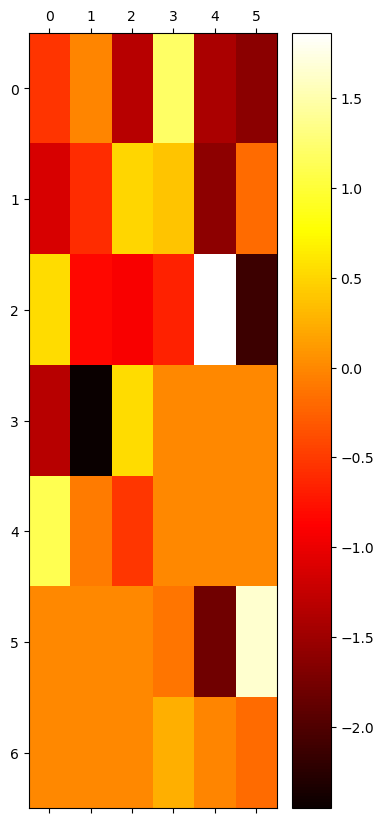

(6, 7)


In [6]:
plt.figure(figsize=(4, 10)) 
plt.matshow(true_F.T, aspect='auto', fignumarker=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_F.shape)

In [7]:
C = hf.generate_data(true_F, true_D_noise, nsamples)

Z = C - C.mean(axis=1, keepdims=True)
A = Z @ Z.T / (Z.shape[1]-1)

# permute to put clusters on diagonal
Y = Z[hpart["rows"]["pi"], :].T
N = Y.shape[0]

In [8]:
ntest = 10**3
C_test = hf.generate_data(true_F, true_D_noise, ntest)

Z_test = C_test - C_test.mean(axis=1, keepdims=True)
# A_test = Z_test @ Z_test.T / (Z_test.shape[1]-1)

# permute to put clusters on diagonal
Y_test = Z_test[hpart["rows"]["pi"], :].T

In [9]:
type(true_F)

numpy.ndarray

In [10]:
perm_true_covariance = true_F @ true_F.T + np.diag(true_D_noise)
np.linalg.norm(A - perm_true_covariance, 'fro') / np.linalg.norm(perm_true_covariance, 'fro') 

0.07044106783028577

In [11]:
C.shape, Z.shape, A.shape

((6, 300), (6, 300), (6, 6))

In [12]:
U, Vt, sigmas = mf.frob_low_rank(A)
frob_losses = np.zeros(n)
normalization = np.linalg.norm(A, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

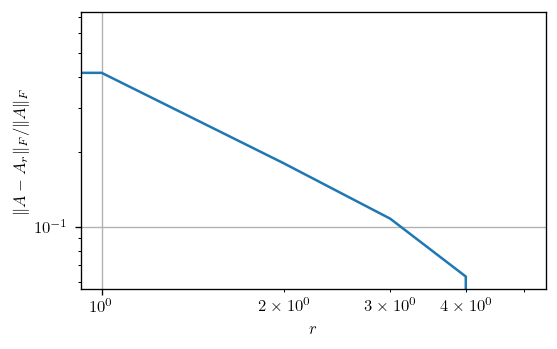

In [13]:
mf.plot_frob_error_rank(frob_losses)

In [14]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [15]:
row_selectors, si_groups, F_hpart = hf.row_col_selections(hpart)

num_levels=3, num_sparsities=2
(2, 2) [0 1]


# MLR Frobenius fit

In [16]:
obj_frobs = {}

print(ranks.sum())
hat_A = mf.MLRMatrix()
hat_A.hpart = hpart
losses = hat_A.factor_fit(A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                printing=False, max_iters_ff=50, symmarker=True)

F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
Sigma_frob = hf.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
lu, piv = scipy.linalg.lu_factor(Sigma_frob)
obj_frob = hf.loglikelihood_value(Sigma_frob, lu, piv, Y)
print(f"{obj_frob = }")
obj_frob_test = hf.loglikelihood_value(Sigma_frob, lu, piv, Y_test)
print(f"{obj_frob_test = }")
obj_frobs[str(ranks)] = {"train":obj_frob, "test":obj_frob_test}

6


/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


obj_frob = -13.654883956930002
obj_frob_test = -13.718831820558709


In [17]:
mf.rel_diff(hat_A.matrix(), den=A)

2.8018145424688223e-15

# EM algorithm

### Random initialization

In [18]:
loglikelihoods = [-np.inf]
F0, D0 = np.random.randn(n, rank-1), np.square(np.random.rand(n)) + 1

In [19]:
for t in range(200):
    Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    obj = hf.loglikelihood_value(Sigma0, lu, piv, Y)
    loglikelihoods += [obj]
    if t % 50 == 0:
        print(f"{t=}, {obj=}")
    F1 = hf.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
    D1 = hf.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
    F0, D0 = F1, D1
    assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]

t=0, obj=-16.099504495108643
t=50, obj=-13.654867255210654
t=100, obj=-13.654867253133459
t=150, obj=-13.654867253133455


In [20]:
ll_hier = np.copy(np.array(loglikelihoods))

In [21]:
Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
mf.rel_diff(Sigma0, den=A[hat_A.pi_rows, :][:, hat_A.pi_cols]) #mf.rel_diff(Sigma0[hat_A.pi_inv_rows, :][:, hat_A.pi_inv_cols], den=A)

0.0033333333333336

In [22]:
lu, piv = scipy.linalg.lu_factor(Sigma0)
obj_test = hf.loglikelihood_value(Sigma0, lu, piv, Y_test)
print(f"train={ll_hier[-1]}, {obj_test=}")
ll_hier = {"train":ll_hier, "test":obj_test}

train=-13.654867253133455, obj_test=-13.71902898921577


In [23]:
obj_frobs

{'[3 2 1]': {'train': -13.654883956930002, 'test': -13.718831820558709}}

In [32]:
true_Sigma = hf.perm_hat_Sigma(true_F, true_D_noise, F_hpart, ranks)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_obj_test = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y_test)
print(f"{true_obj_test=}")

true_obj_test=-16.329901873168435


In [28]:
obj_frobs = {}
obj_ml = {}
obj_true = {}
for nsamples in [500, 10**3, 10**4, 10**5, 10**6]:
    print(f"{nsamples=}")
    C = hf.generate_data(true_F, true_D_noise, nsamples)

    Z = C - C.mean(axis=1, keepdims=True)
    A = Z @ Z.T / (Z.shape[1]-1)

    # permute to put clusters on diagonal
    Y = Z[hpart["rows"]["pi"], :].T

    true_train_obj = hf.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
    obj_true[nsamples] = true_train_obj
    print(f"TR: train ll={true_train_obj}, test ll={true_obj_test}")
    
    
    # frobenius fit
    hat_A = mf.MLRMatrix()
    hat_A.hpart = hpart
    losses = hat_A.factor_fit(A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                    printing=False, max_iters_ff=50, symmarker=True)

    F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
    Sigma_frob = hf.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
    lu, piv = scipy.linalg.lu_factor(Sigma_frob)
    obj_frob = hf.loglikelihood_value(Sigma_frob, lu, piv, Y)
    obj_frob_test = hf.loglikelihood_value(Sigma_frob, lu, piv, Y_test)
    print(f"FR: train ll={obj_frob}, test ll={obj_frob_test}, {losses[-1]=}")
    obj_frobs[nsamples] = {"train":obj_frob, "test":obj_frob_test}

    # ML fit
    loglikelihoods, F0, D0 = hf.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, ranks, max_iter=200, 
                 eps=1e-12, printing=False)
    Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    obj_test = hf.loglikelihood_value(Sigma0, lu, piv, Y_test)
    print(f"ML: train ll={loglikelihoods[-1]}, test ll={obj_test}")
    obj_ml[nsamples] = {"train":loglikelihoods[-1], "test":obj_test}

nsamples=500
TR: train ll=-16.272949301141633, test ll=-16.329901873168435
FR: train ll=-13.688156971639193, test ll=-13.711223516837224, losses[-1]=3.874058719323402e-11
terminating at t=104
ML: train ll=-13.688150963679337, test ll=-13.711263378977987
nsamples=1000
TR: train ll=-16.149159538405424, test ll=-16.329901873168435
FR: train ll=-13.625421141759135, test ll=-13.691865424193562, losses[-1]=2.6256341837861246e-15
terminating at t=171
ML: train ll=-13.625419640848104, test ll=-13.691930406578695
nsamples=10000
TR: train ll=-16.435650162662885, test ll=-16.329901873168435
FR: train ll=-13.68154654883273, test ll=-13.688970410342248, losses[-1]=7.38730775484828e-15
terminating at t=105
ML: train ll=-13.681546533880345, test ll=-13.688971315881666
nsamples=100000
TR: train ll=-16.409106350459027, test ll=-16.329901873168435
FR: train ll=-13.686845456614929, test ll=-13.687556572042986, losses[-1]=5.1738135064826706e-14
terminating at t=150
ML: train ll=-13.686845456547942, test l

In [26]:
obj_ml

{500: {'train': -13.770630094885426, 'test': -13.702711468384173},
 1000: {'train': -13.652877700656642, 'test': -13.693948173639502},
 10000: {'train': -13.688345798331763, 'test': -13.69018549515469},
 100000: {'train': -13.681740544380858, 'test': -13.687839943795298},
 1000000: {'train': -13.685500733491663, 'test': -13.687591775054317}}

In [27]:
obj_frobs

{500: {'train': -13.770636102854969, 'test': -13.702853524745809},
 1000: {'train': -13.652879201587671, 'test': -13.693908888766416},
 10000: {'train': -13.688345813273875, 'test': -13.690185715034982},
 100000: {'train': -13.681740544467473, 'test': -13.687839963053808},
 1000000: {'train': -13.685500733418246, 'test': -13.687591743669476}}

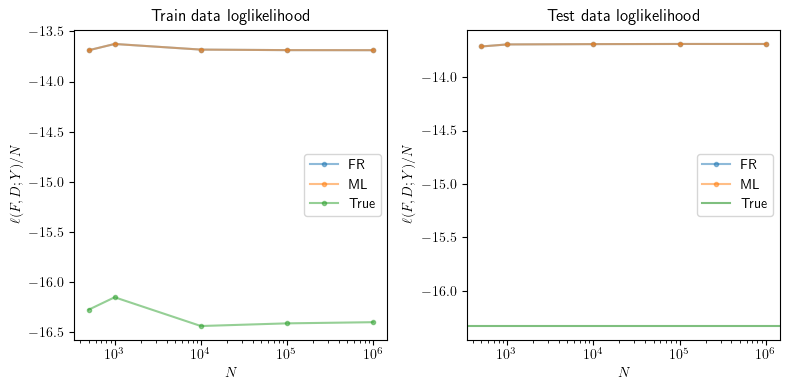

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

x = list(obj_frobs.keys())
# First subplot
ax1.plot(x, [obj_frobs[ns]["train"] for ns in x], label='FR', marker='.', alpha=0.5)
ax1.plot(x, [obj_ml[ns]["train"] for ns in x], label='ML', marker='.', alpha=0.5)
ax1.plot(x, [obj_true[ns] for ns in x], label='True', marker='.', alpha=0.5)
ax1.set_title('Train data loglikelihood')
ax1.set_xscale('log')
ax1.set_ylabel('$\ell(F, D; Y)/N$')
ax1.set_xlabel('$N$')
ax1.legend()

# Second subplot with different example data (modify as needed)
ax2.plot(x, [obj_frobs[ns]["test"] for ns in x], label='FR', marker='.', alpha=0.5)
ax2.plot(x, [obj_ml[ns]["test"] for ns in x], label='ML', marker='.', alpha=0.5)
ax2.axhline(y=true_obj_test, label='True', c='g', alpha=0.5)
ax2.set_title('Test data loglikelihood')
ax2.set_ylabel('$\ell(F, D; Y)/N$')
ax2.set_xlabel('$N$')
ax2.set_xscale('log')
ax2.legend()

plt.tight_layout() 
plt.savefig("ml_train_test.pdf", bbox_inches='tight')
plt.show()